# Loading packages

In [1]:
from __future__ import print_function, division 
import pandas as pd 
from pandas import Series, DataFrame 
from matplotlib import pyplot as plt
import numpy as np
from datetime import date
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

SavePlots = False

# Data

### Loading and splitting data

In [7]:
data = pd.read_csv('../Final-Project-AppML/feds200628.csv', skiprows=9)

remove non-essential rows, columns and Nan

In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data1 = data[data['Date'] >= '1985-01-02']

col_to_keep = ['Date']
sveny_cols = [col for col in data.columns if col.startswith('SVENY')]
all_keep_cols = col_to_keep + sveny_cols
data2 = data1[all_keep_cols]
columns_to_drop = [f'SVENY{i}' for i in range(21, 31)]
data2 = data2.drop(columns=columns_to_drop, errors='ignore')

plot_data =data2
plot_data.rename(columns=lambda col: col[5:] if col.startswith('SVENY') else col, inplace=True)
plot_data.rename(columns=lambda col: str(int(col)) if col.isdigit() else col, inplace=True)

data = plot_data.dropna()
data['Date'] = pd.to_datetime(data['Date']).dt.date

train = data[data['Date'] >= date(1985, 1, 2)]
train = train[train['Date'] <= date(2017, 12, 31)] 

valid = data[data['Date'] >= date(2018, 1, 1)] 
valid = valid[valid['Date'] <= date(2024, 12, 31)] 

test = data[data['Date'] >= date(2025, 1, 1)] 

/var/folders/lj/7sv2y2pj44184gp5gwhj9d5w0000gn/T/ipykernel_97567/1234211664.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date']).dt.date


___

### Data overview

Histogram of yield 2 and 20

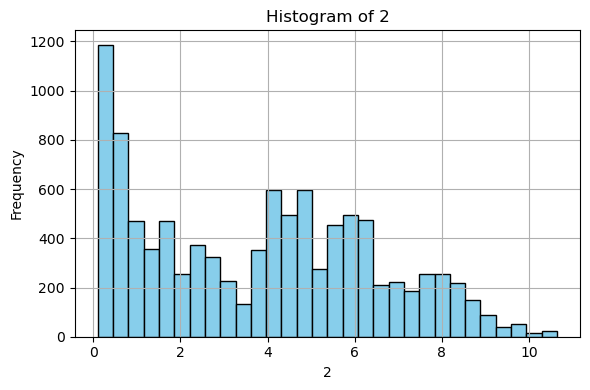

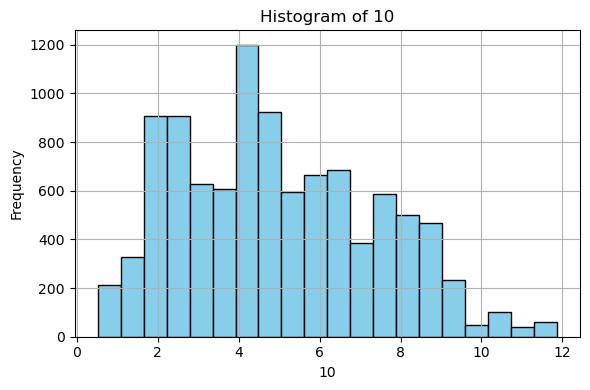

In [9]:
def plot_histogram(column_name, bins=30):
    if column_name not in plot_data.columns:
        print(f"Column '{column_name}' not found in data.")
        return

    plt.figure(figsize=(6, 4))
    plt.hist(plot_data[column_name].dropna(), bins=bins, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_histogram('2')
plot_histogram('10', bins=20) 


3D plot of all type of yields

/var/folders/lj/7sv2y2pj44184gp5gwhj9d5w0000gn/T/ipykernel_97567/3572421373.py:24: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


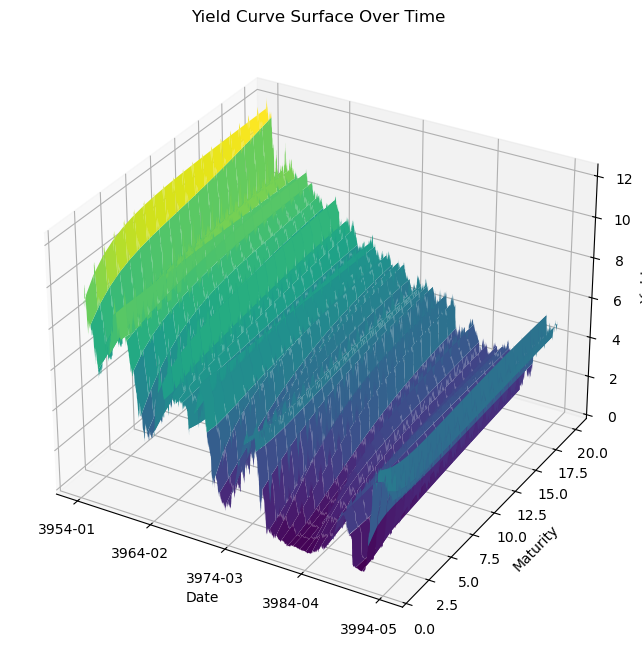

In [10]:
X = plot_data['Date'].map(pd.Timestamp.toordinal).values

maturity_cols = sorted([col for col in plot_data.columns if col.isdigit()], key=lambda x: int(x))
Y = np.array([int(m) for m in maturity_cols]) 

Z = plot_data[maturity_cols].values

X_mesh, Y_mesh = np.meshgrid(X, Y, indexing='ij')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis')

ax.set_xlabel('Date')
ax.set_ylabel('Maturity')
ax.set_zlabel('Yield')
ax.set_title('Yield Curve Surface Over Time')

from matplotlib.dates import num2date
ax.set_xticks(np.linspace(X.min(), X.max(), 5))
ax.set_xticklabels([num2date(t).strftime('%Y-%m') for t in np.linspace(X.min(), X.max(), 5)])

plt.tight_layout()
plt.show()

Plot of all data of yield type 2 and 20

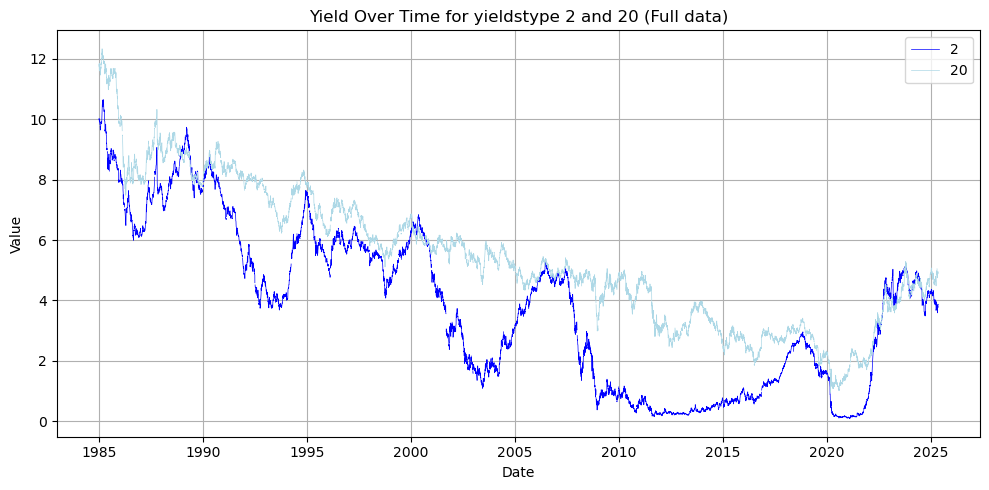

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(plot_data['Date'], plot_data['2'], label='2', color='blue', linewidth=0.5)
plt.plot(plot_data['Date'], plot_data['20'], label='20', color='lightblue', linewidth=0.5)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Yield Over Time for yieldstype 2 and 20 (Full data)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

# Predicting yields

## Baseline

## GRU 

### Yield type 2

makeing the model

In [66]:
maturity_col = '2'
time_step = 20
future_days = 1

# === Extract and scale the selected maturity ===
train_vals = train[[maturity_col]].values
val_vals = valid[[maturity_col]].values
test_vals = test[[maturity_col]].values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
val_scaled = scaler.transform(val_vals)
test_scaled = scaler.transform(test_vals)

# === Create dataset ===
def create_multistep_dataset(data, time_step=60, future_days=10):
    X, y = [], []
    for i in range(len(data) - time_step - future_days):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + future_days, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_dataset(train_scaled, time_step, future_days)
X_val, y_val = create_multistep_dataset(val_scaled, time_step, future_days)
X_test, y_test = create_multistep_dataset(test_scaled, time_step, future_days)

X_train = X_train.reshape((-1, time_step, 1))
X_val = X_val.reshape((-1, time_step, 1))
X_test = X_test.reshape((-1, time_step, 1))

# === GRU model ===
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dense(units=future_days))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# === Train model ===
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=-1)

Epoch 1/20


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


___

Predict

In [ ]:

predicted_scaled = model.predict(X_test)
true_scaled = y_test

predicted = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
true = scaler.inverse_transform(true_scaled.reshape(-1, 1))


aligned_test_dates = test['Date'].values[-len(y_test):]
expected_len = len(y_test)
aligned_test_dates = test['Date'].values[-expected_len:]

predicted = predicted.flatten()
true = true.flatten()

Plot predictions

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_dates, true, label='True', color='blue')
plt.plot(aligned_test_dates, predicted, label='Predicted', color = 'lightblue')
plt.title(f"Predicted yield for type 2\nMSE = {mean_squared_error(true_all, predicted_all):.6f}")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Yield type 20

making the model

In [65]:
maturity_col = '20'
time_step = 20
future_days = 1

# === Extract and scale the selected maturity ===
train_vals = train[[maturity_col]].values
val_vals = valid[[maturity_col]].values
test_vals = test[[maturity_col]].values

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_vals)
val_scaled = scaler.transform(val_vals)
test_scaled = scaler.transform(test_vals)

# === Create dataset ===
def create_multistep_dataset(data, time_step=60, future_days=10):
    X, y = [], []
    for i in range(len(data) - time_step - future_days):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step:i + time_step + future_days, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_multistep_dataset(train_scaled, time_step, future_days)
X_val, y_val = create_multistep_dataset(val_scaled, time_step, future_days)
X_test, y_test = create_multistep_dataset(test_scaled, time_step, future_days)

X_train = X_train.reshape((-1, time_step, 1))
X_val = X_val.reshape((-1, time_step, 1))
X_test = X_test.reshape((-1, time_step, 1))

# === GRU model ===
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dense(units=future_days))
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# === Train model ===
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=-1)

Epoch 1/20


/opt/anaconda3/envs/AppML/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


## XGBoost

# Data for predicting stock prices and interest rates

## Importing and filtering

In [12]:
import pandas as pd
data = pd.read_csv('../Final-Project-AppML/feds200628.csv', skiprows=9)

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter rows where Date is on or after 1985-01-02
data1 = data[data['Date'] >= '1985-01-02']

# List of columns to keep always
cols_to_keep = ['Date', 'BETA0', 'BETA1', 'BETA2']

# Select columns that start with 'SVENY'
sveny_cols = [col for col in data.columns if col.startswith('SVENY')]

# Combine all columns to keep
all_keep_cols = cols_to_keep + sveny_cols

# Filter the dataframe to keep only these columns
data2 = data1[all_keep_cols]

# Drop SVENY21 to SVENY30 from data2
columns_to_drop = [f'SVENY{i}' for i in range(21, 31)]
data2 = data2.drop(columns=columns_to_drop, errors='ignore')

# Skip the first two rows, but manually set row 2 (i.e. 0-based row index 2) as header
SP_500_historic = pd.read_csv('../Final-Project-AppML/SP_historic.csv', skiprows=2, header=0)

# Now 'Date' should be in ISO format already, so you can parse it without specifying a format
SP_500_historic['Date'] = pd.to_datetime(SP_500_historic['Date'])

# If you want it as 'YYYY-MM-DD' string format
SP_500_historic['Date'] = SP_500_historic['Date'].dt.strftime('%Y-%m-%d')

# Preview
SP_500_historic.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Skip the first 9 rows
fed_interest = pd.read_csv('../Final-Project-AppML/FED_interest.csv')

# Ensure both Date columns are datetime
data2['Date'] = pd.to_datetime(data2['Date'])
SP_500_historic['Date'] = pd.to_datetime(SP_500_historic['Date'])
fed_interest['Date'] = pd.to_datetime(fed_interest['Date'])

# Now do the merge
data_w_SP = pd.merge(data2, SP_500_historic, on='Date', how='left')

data_w_SP = pd.merge(data_w_SP, fed_interest, on='Date', how='left')

# Ensure 'Date' is in datetime format
data_w_SP['Date'] = pd.to_datetime(data_w_SP['Date'])

# Filter by date
data_w_SP = data_w_SP[data_w_SP['Date'] >= '1991-01-09']

# Drop BETA columns and 'Target Rate (%)' column
data_w_SP = data_w_SP.loc[:, ~data_w_SP.columns.str.startswith('BETA')]
data_w_SP = data_w_SP.drop(columns='Target Rate (%)', errors='ignore')
#data_w_SP = data_w_SP.drop(columns='Notes', errors='ignore') # Forlæng
#data_w_SP = data_w_SP.drop(columns='Rate Change (bps)', errors='ignore') #Forlæng

# Convert 'Notes' and 'Rate Change (bps)' to integers, if they exist
for col in ['Notes', 'Rate Change (bps)']:
    if col in data_w_SP.columns:
        data_w_SP[col] = pd.to_numeric(data_w_SP[col], errors='coerce').astype('Int64')  # Nullable integer type

In [13]:
df = data_w_SP.dropna()

## Splitting the data

In [14]:
import pandas as pd

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define the cutoff dates
train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

# Create the splits
train_df = df[df['Date'] < train_end]
val_df = df[(df['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = df[df['Date'] >= val_end]

# Optionally check the sizes
print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")


Train set: 6722 rows
Validation set: 1748 rows
Test set: 88 rows


/var/folders/lj/7sv2y2pj44184gp5gwhj9d5w0000gn/T/ipykernel_97567/160201209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


# Predicting stock prices

## Making a XGboost models - Validation set

### Predicting with XGboost with time series

#### Baseline model

In [87]:
df.head()

,Date,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,...,SVENY20,Close,High,Low,Open,Volume,FEDFUNDS,Notes,Rate Change (bps),year
1570,1991-01-09,6.841287,7.133531,7.389677,7.613145,7.807043,7.974199,8.117182,8.238325,8.339752,...,8.597437,311.489990,320.730011,310.929993,314.899994,191100000.0,6.91,0,-25,1991
1571,1991-01-10,6.799324,7.089104,7.339749,7.555624,7.740626,7.898230,8.031535,8.143304,8.236000,...,8.481158,314.529999,314.769989,311.510010,311.510010,124510000.0,6.91,0,0,1991
1572,1991-01-11,6.773037,7.085764,7.351627,7.576813,7.766714,7.926027,8.058841,8.168714,8.258740,...,8.504820,315.230011,315.239990,313.589996,314.529999,123050000.0,6.91,0,0,1991
1573,1991-01-14,6.777678,7.110425,7.385916,7.613962,7.802602,7.958424,8.086828,8.192242,8.278296,...,8.520263,312.489990,315.230011,309.350006,315.230011,120830000.0,6.91,0,0,1991
1574,1991-01-15,6.752939,7.099241,7.371627,7.591270,7.772313,7.924163,8.053062,8.163160,8.257241,...,8.562148,313.730011,313.730011,311.839996,312.489990,110000000.0,6.91,0,0,1991


In [88]:
def add_date_features(df, date_col='Date'):
    df = df.copy()
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['weekday'] = df[date_col].dt.weekday
    df['dayofyear'] = df[date_col].dt.dayofyear
    return df

def prepare_lagged_data_with_date_features(train_df, val_df, target_col, lags=[1, 2, 3], date_col='Date'):
    def create_lags(df, target_col, lags):
        df = df.copy()
        for lag in lags:
            df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
        return df

    # Add date features
    train_df = add_date_features(train_df, date_col)
    val_df = add_date_features(val_df, date_col)

    # Create lagged features
    train_data = create_lags(train_df, target_col, lags)
    val_data = create_lags(val_df, target_col, lags)

    # Drop rows with NaNs due to lag shifts
    train_data = train_data.dropna()
    val_data = val_data.dropna()

    # Split into X and y
    X_train = train_data.drop(columns=[target_col, date_col])
    y_train = train_data[target_col]

    X_val = val_data.drop(columns=[target_col, date_col])
    y_val = val_data[target_col]

    return X_train, y_train, X_val, y_val


# Example usage:
target = 'Close'
X_train, y_train, X_val, y_val = prepare_lagged_data_with_date_features(train_df, val_df, target)



In [89]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred)

mean_abs_actual = abs(y_val).mean()
relative_mae = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 1331.3236
Relative MAE: 0.3456
Time used by XGBoost: 333.5 ms


#### Feature importance

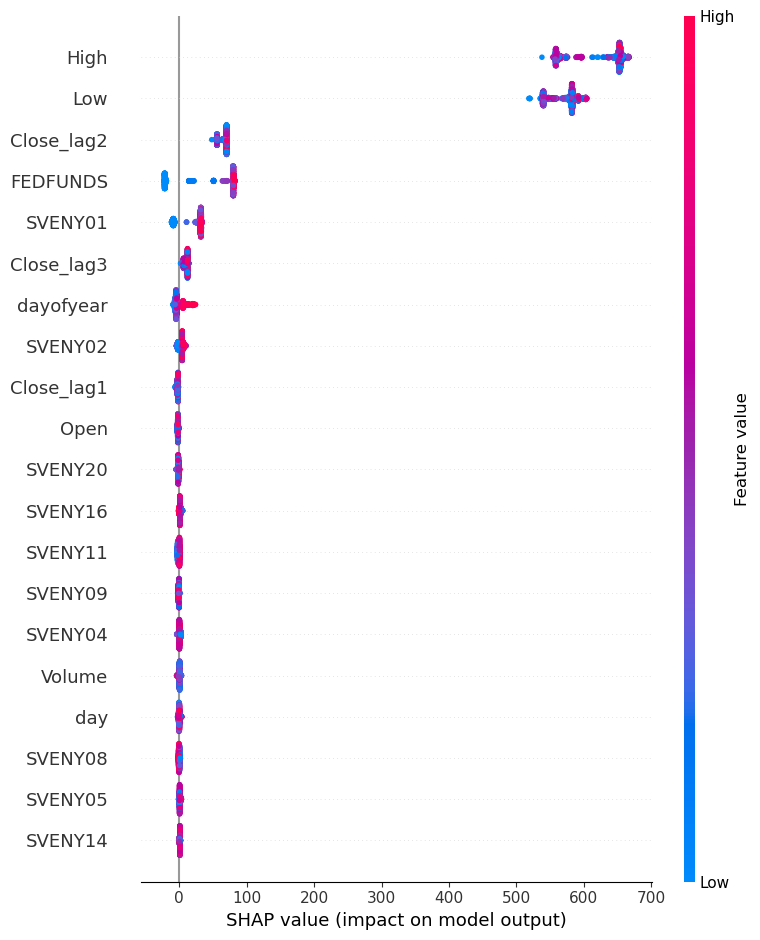

In [90]:
import shap

# Create a SHAP explainer for your XGBoost model
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for your test set
shap_values = explainer(X_val)

# Summary plot (shows feature importance and effect)
shap.summary_plot(shap_values, X_val)


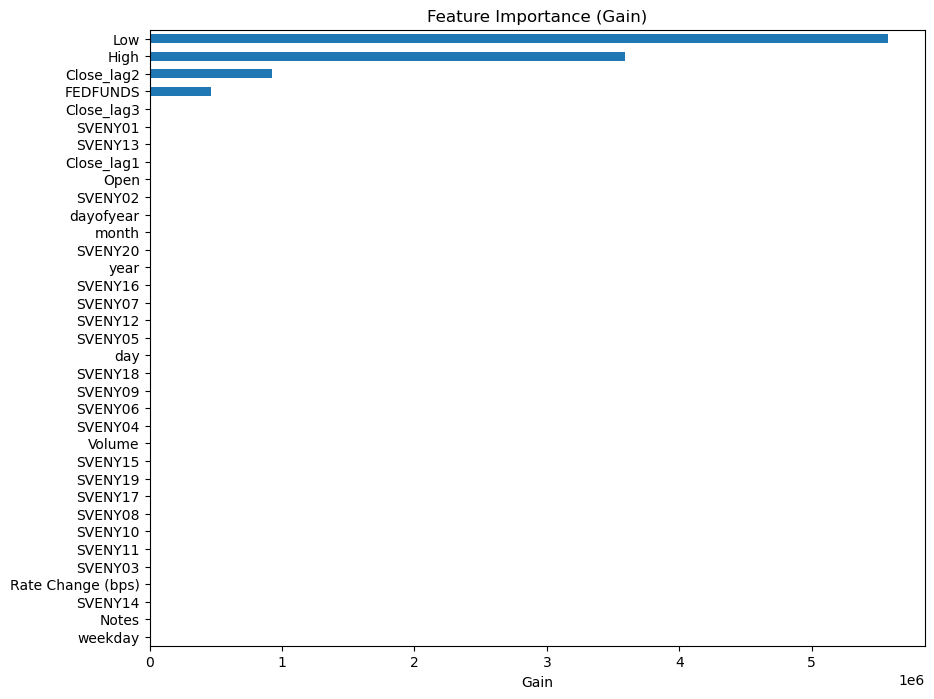

In [91]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance scores by 'gain'
importance = xgb_model.get_score(importance_type='gain')

# Convert to pandas Series for easier plotting and sorting
import pandas as pd
importance_series = pd.Series(importance).sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 8))
importance_series.plot(kind='barh')
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.show()


#### Only predicting on ZCB data but with lags

In [92]:
data_ZCB = df.drop(columns=['Open', 'High', 'Low', 'Volume'])

In [93]:
import pandas as pd

# Ensure the 'Date' column is in datetime format
data_ZCB['Date'] = pd.to_datetime(data_ZCB['Date'])

# Define the cutoff dates
train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

# Create the splits
train_df = data_ZCB[data_ZCB['Date'] < train_end]
val_df = data_ZCB[(data_ZCB['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = data_ZCB[data_ZCB['Date'] >= val_end]

# Optionally check the sizes
print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 6722 rows
Validation set: 1748 rows
Test set: 88 rows


In [94]:
def add_date_features(df, date_col='Date'):
    df = df.copy()
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['weekday'] = df[date_col].dt.weekday
    df['dayofyear'] = df[date_col].dt.dayofyear
    return df

def prepare_lagged_data_with_date_features(train_df, val_df, target_col, lags=[1, 2, 3], date_col='Date'):
    def create_lags(df, target_col, lags):
        df = df.copy()
        for lag in lags:
            df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
        return df

    # Add date features
    train_df = add_date_features(train_df, date_col)
    val_df = add_date_features(val_df, date_col)

    # Create lagged features
    train_data = create_lags(train_df, target_col, lags)
    val_data = create_lags(val_df, target_col, lags)

    # Drop rows with NaNs due to lag shifts
    train_data = train_data.dropna()
    val_data = val_data.dropna()

    # Split into X and y
    X_train = train_data.drop(columns=[target_col, date_col])
    y_train = train_data[target_col]

    X_val = val_data.drop(columns=[target_col, date_col])
    y_val = val_data[target_col]

    return X_train, y_train, X_val, y_val


# Example usage:
target = 'Close'
X_train, y_train, X_val, y_val = prepare_lagged_data_with_date_features(train_df, val_df, target)

In [95]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred)

mean_abs_actual = abs(y_val).mean()
relative_mae_wo_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 1331.3236
Relative MAE: 0.3456
Time used by XGBoost: 131.9 ms


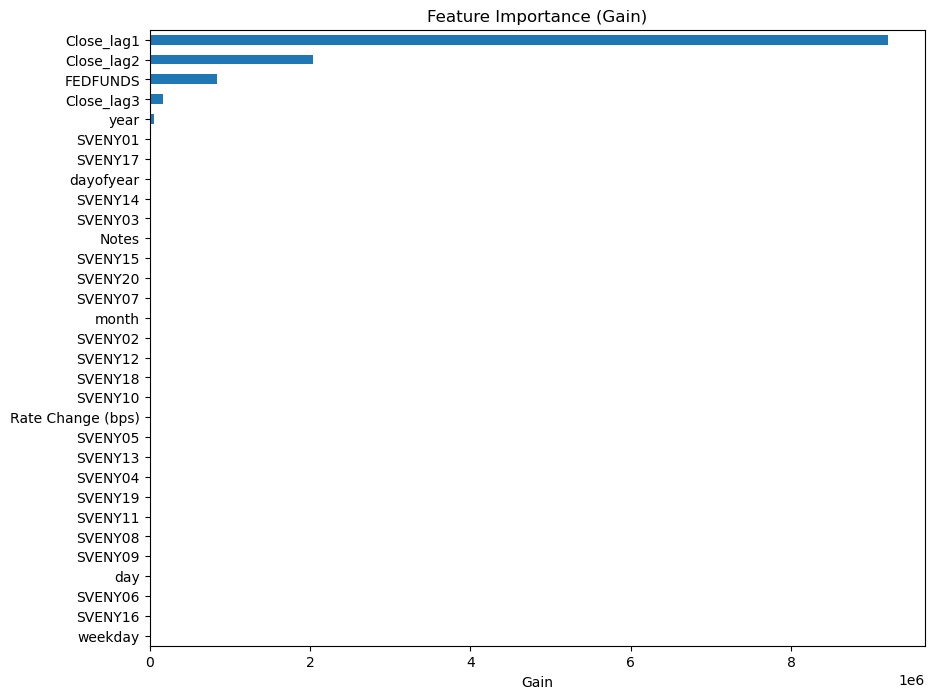

In [96]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance scores by 'gain'
importance = xgb_model.get_score(importance_type='gain')

# Convert to pandas Series for easier plotting and sorting
import pandas as pd
importance_series = pd.Series(importance).sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 8))
importance_series.plot(kind='barh')
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.show()

#### Only predicting on stock but with lags

In [97]:
data_stock = df[['Date', 'Open', 'High', 'Low', 'Volume', 'Close']]

In [98]:
import pandas as pd

# Ensure the 'Date' column is in datetime format
data_stock['Date'] = pd.to_datetime(data_stock['Date'])

# Define the cutoff dates
train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

# Create the splits
train_df = data_stock[data_stock['Date'] < train_end]
val_df = data_stock[(data_stock['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = data_stock[data_stock['Date'] >= val_end]

# Optionally check the sizes
print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 6722 rows
Validation set: 1748 rows
Test set: 88 rows


/var/folders/lj/7sv2y2pj44184gp5gwhj9d5w0000gn/T/ipykernel_97567/1885972986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_stock['Date'] = pd.to_datetime(data_stock['Date'])


In [99]:
def add_date_features(df, date_col='Date'):
    df = df.copy()
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['weekday'] = df[date_col].dt.weekday
    df['dayofyear'] = df[date_col].dt.dayofyear
    return df

def prepare_lagged_data_with_date_features(train_df, val_df, target_col, lags=[1, 2, 3], date_col='Date'):
    def create_lags(df, target_col, lags):
        df = df.copy()
        for lag in lags:
            df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
        return df

    # Add date features
    train_df = add_date_features(train_df, date_col)
    val_df = add_date_features(val_df, date_col)

    # Create lagged features
    train_data = create_lags(train_df, target_col, lags)
    val_data = create_lags(val_df, target_col, lags)

    # Drop rows with NaNs due to lag shifts
    train_data = train_data.dropna()
    val_data = val_data.dropna()

    # Split into X and y
    X_train = train_data.drop(columns=[target_col, date_col])
    y_train = train_data[target_col]

    X_val = val_data.drop(columns=[target_col, date_col])
    y_val = val_data[target_col]

    return X_train, y_train, X_val, y_val


# Example usage:
target = 'Close'
X_train, y_train, X_val, y_val = prepare_lagged_data_with_date_features(train_df, val_df, target)

In [100]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred)

mean_abs_actual = abs(y_val).mean()
relative_mae_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 1331.3236
Relative MAE: 0.3456
Time used by XGBoost: 147.7 ms


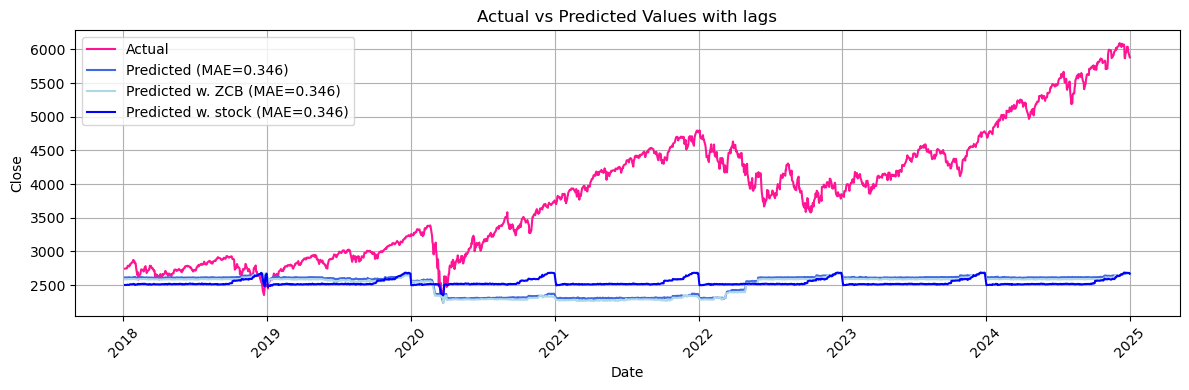

In [101]:
import matplotlib.pyplot as plt

# Extract date from val_df to align with y_val
dates = val_df.loc[y_val.index, 'Date']

plt.figure(figsize=(12, 4))
plt.plot(dates, y_val, label='Actual', color='deeppink')
plt.plot(dates, y_pred, label=f'Predicted (MAE={relative_mae:.3f})', color='royalblue')
plt.plot(dates, y_pred_ZCB, label=f'Predicted w. ZCB (MAE={relative_mae_wo_stock:.3f})', color='lightblue')
plt.plot(dates, y_pred_stock, label=f'Predicted w. stock (MAE={relative_mae_stock:.3f})', color='blue')

plt.xlabel('Date')
plt.ylabel(target)  # Assuming 'target' is defined elsewhere
plt.title('Actual vs Predicted Values with lags')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



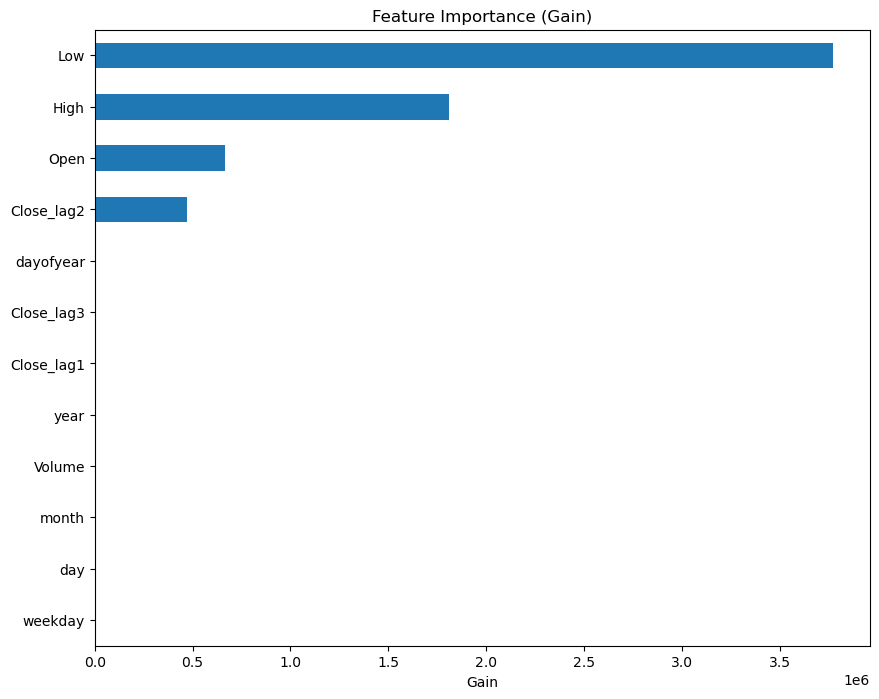

In [102]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance scores by 'gain'
importance = xgb_model.get_score(importance_type='gain')

# Convert to pandas Series for easier plotting and sorting
import pandas as pd
importance_series = pd.Series(importance).sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 8))
importance_series.plot(kind='barh')
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.show()

### Predicting with XGboost

In [103]:
import pandas as pd

# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define the cutoff dates
train_end = pd.Timestamp('2018-01-01')
val_end = pd.Timestamp('2025-01-01')

# Create the splits
train_df = df[df['Date'] < train_end]
val_df = df[(df['Date'] >= train_end) & (df['Date'] < val_end)]
test_df = df[df['Date'] >= val_end]

# Optionally check the sizes
print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 6722 rows
Validation set: 1748 rows
Test set: 88 rows


#### Predicting with stock data

In [104]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

target = 'Close'

# Start timer
start = time.time()

# Drop rows with any missing values from train and test
train_data_clean = train_df.dropna()
val_data_clean = val_df.dropna()

# Prepare features and target again after dropping NA rows
X_train = train_data_clean.drop(columns=[target, 'Date'])
y_train = train_data_clean[target]

X_val = val_data_clean.drop(columns=[target, 'Date'])
y_val = val_data_clean[target]

# Now create DMatrices for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)


# XGBoost parameters
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

# Train model with early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

# Predict and evaluate
y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred)
relative_mae = mae / abs(y_val).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")



Mean Absolute Error: 1292.4242
Relative MAE: 0.3357
Time used by XGBoost: 281.7 ms


#### Predicting without stock data

In [105]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

# Drop rows with any missing values from train and test first
train_data_clean = train_df.dropna()
val_data_clean = val_df.dropna()

# Define columns to drop including target, date, and Open/High/Low
cols_to_drop = [target, 'Date', 'Open', 'High', 'Low', 'Volume']

# Prepare features and target after dropping NA rows
X_train = train_data_clean.drop(columns=cols_to_drop)
y_train = train_data_clean[target]

X_val = val_data_clean.drop(columns=cols_to_drop)
y_val = val_data_clean[target]

# Start timer
start = time.time()

# Create DMatrices for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

# XGBoost parameters
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

# Train model with early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

# Predict and evaluate
y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred_ZCB)
relative_mae_wo_stock = mae / abs(y_val).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")




Mean Absolute Error: 1429.8386
Relative MAE: 0.3357
Time used by XGBoost: 112.3 ms


#### Predicting only stock data

In [106]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

# Drop rows with any missing values from train and test first
train_data_clean = train_df.dropna()
val_data_clean = val_df.dropna()

# Select only Open, High, Low as features
feature_cols = ['Open', 'High', 'Low', 'Volume']

# Prepare features and target after drop,ping NA rows
X_train = train_data_clean[feature_cols]
y_train = train_data_clean[target]

X_val = val_data_clean[feature_cols]
y_val = val_data_clean[target]

# Start timer
start = time.time()

# Create DMatrices for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

# XGBoost parameters
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

# Train model with early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

# Predict and evaluate
y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(y_val, y_pred_stock)
relative_mae_stock = mae / abs(y_val).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")




Mean Absolute Error: 1203.7324
Relative MAE: 0.3357
Time used by XGBoost: 79.4 ms


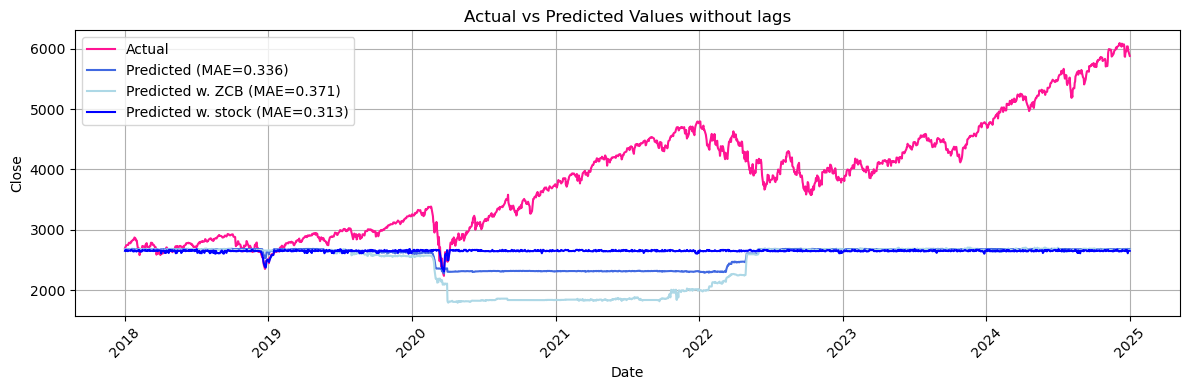

In [107]:
import matplotlib.pyplot as plt

# Assuming you still have test_data_clean (with dropped NAs) and predictions y_pred

# Make predictions
y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))

plt.figure(figsize=(12, 4))
plt.plot(val_data_clean['Date'], y_val, label='Actual', color='deeppink')
plt.plot(val_data_clean['Date'], y_pred, label=f'Predicted (MAE={relative_mae:.3f})', color='royalblue')
plt.plot(val_data_clean['Date'], y_pred_ZCB, label=f'Predicted w. ZCB (MAE={relative_mae_wo_stock:.3f})', color='lightblue')
plt.plot(val_data_clean['Date'], y_pred_stock, label=f'Predicted w. stock (MAE={relative_mae_stock:.3f})', color='blue')

plt.xlabel('Date')
plt.ylabel(target)
plt.title('Actual vs Predicted Values without lags')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Predicting using an expanding window

### Predicting using a time window using all features

In [108]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Configuration
target = 'Close'
start_train_year = 2000
end_val_year = 2025  # inclusive

# Ensure data is sorted
df = df.sort_values('Date').copy()
df['year'] = df['Date'].dt.year

# Store results
results = []

for val_year in range(start_train_year + 1, end_val_year + 1):
    print(f"\n🔁 Training up to {val_year - 1}, validating on {val_year}")

    # Train: all years up to (not including) val_year
    train_data = df[df['year'] < val_year]
    val_data = df[df['year'] == val_year]

    # Drop if validation is empty
    if val_data.empty:
        print(f"⚠️ No validation data for {val_year}")
        continue

    # Define X/y
    X_train = train_data.drop(columns=[target, 'Date', 'year'])
    y_train = train_data[target]
    X_val = val_data.drop(columns=[target, 'Date', 'year'])
    y_val = val_data[target]

    # Train model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'verbosity': 0
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'val')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predict
    y_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

    # Evaluate
    mae = mean_absolute_error(y_val, y_pred)
    rel_mae = mae / abs(y_val.mean())
    results.append({
        'Validation Year': val_year,
        'MAE': mae,
        'Relative MAE': rel_mae
    })
    print(f"✅ MAE: {mae:.4f}, Relative MAE: {rel_mae:.4f}")

# Convert to DataFrame
cv_results = pd.DataFrame(results)
print("\n📊 Cross-Validation Summary:")
print(cv_results)



🔁 Training up to 2000, validating on 2001
✅ MAE: 9.0085, Relative MAE: 0.0075

🔁 Training up to 2001, validating on 2002
✅ MAE: 8.9977, Relative MAE: 0.0090

🔁 Training up to 2002, validating on 2003
✅ MAE: 8.1686, Relative MAE: 0.0085

🔁 Training up to 2003, validating on 2004
✅ MAE: 4.2623, Relative MAE: 0.0038

🔁 Training up to 2004, validating on 2005
✅ MAE: 5.3569, Relative MAE: 0.0044

🔁 Training up to 2005, validating on 2006
✅ MAE: 6.6739, Relative MAE: 0.0051

🔁 Training up to 2006, validating on 2007
✅ MAE: 12.9979, Relative MAE: 0.0088

🔁 Training up to 2007, validating on 2008
✅ MAE: 10.8117, Relative MAE: 0.0088

🔁 Training up to 2008, validating on 2009
✅ MAE: 7.2828, Relative MAE: 0.0077

🔁 Training up to 2009, validating on 2010
✅ MAE: 7.5074, Relative MAE: 0.0066

🔁 Training up to 2010, validating on 2011
✅ MAE: 12.9215, Relative MAE: 0.0102

🔁 Training up to 2011, validating on 2012
✅ MAE: 5.6348, Relative MAE: 0.0041

🔁 Training up to 2012, validating on 2013
✅ MAE:

In [109]:
# Print as a nice table
print("\n📊 Cross-Validation Summary (sorted by year):")
print(cv_results.to_string(index=False))



📊 Cross-Validation Summary (sorted by year):
 Validation Year        MAE  Relative MAE
            2001   9.008517      0.007538
            2002   8.997678      0.009043
            2003   8.168606      0.008469
            2004   4.262258      0.003770
            2005   5.356858      0.004437
            2006   6.673918      0.005093
            2007  12.997901      0.008800
            2008  10.811740      0.008837
            2009   7.282839      0.007691
            2010   7.507383      0.006588
            2011  12.921546      0.010191
            2012   5.634759      0.004086
            2013 119.281513      0.072599
            2014 119.810708      0.062040
            2015  29.513303      0.014319
            2016  39.444598      0.018836
            2017 238.159892      0.097226
            2018  94.853576      0.034546
            2019  73.860869      0.025360
            2020 311.644307      0.096929
            2021 596.718559      0.139697
            2022  87.818681   

### Predicting using a time window using stock features

In [110]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Configuration
target = 'Close'
features = ['High', 'Low', 'Open', 'Volume']
start_train_year = 2000
end_val_year = 2025  # inclusive

# Ensure data is sorted
df = df.sort_values('Date').copy()
df['year'] = df['Date'].dt.year

# Store results
results = []

for val_year in range(start_train_year + 1, end_val_year + 1):
    print(f"\n🔁 Training up to {val_year - 1}, validating on {val_year}")

    # Train: all years up to (not including) val_year
    train_data = df[df['year'] < val_year]
    val_data = df[df['year'] == val_year]

    # Drop if validation is empty
    if val_data.empty:
        print(f"⚠️ No validation data for {val_year}")
        continue

    # Define X/y
    X_train = train_data[features]
    y_train = train_data[target]
    X_val = val_data[features]
    y_val = val_data[target]

    # Train model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'verbosity': 0
    }

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'val')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predict
    y_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

    # Evaluate
    mae = mean_absolute_error(y_val, y_pred)
    rel_mae = mae / abs(y_val.mean())
    results.append({
        'Validation Year': val_year,
        'MAE': mae,
        'Relative MAE': rel_mae
    })
    print(f"✅ MAE: {mae:.4f}, Relative MAE: {rel_mae:.4f}")

# Convert to DataFrame
cv_result_stock = pd.DataFrame(results)
print("\n📊 Cross-Validation Summary:")
print(cv_result_stock)



🔁 Training up to 2000, validating on 2001
✅ MAE: 9.1709, Relative MAE: 0.0077

🔁 Training up to 2001, validating on 2002
✅ MAE: 8.6610, Relative MAE: 0.0087

🔁 Training up to 2002, validating on 2003
✅ MAE: 5.4016, Relative MAE: 0.0056

🔁 Training up to 2003, validating on 2004
✅ MAE: 4.1486, Relative MAE: 0.0037

🔁 Training up to 2004, validating on 2005
✅ MAE: 5.2737, Relative MAE: 0.0044

🔁 Training up to 2005, validating on 2006
✅ MAE: 6.0672, Relative MAE: 0.0046

🔁 Training up to 2006, validating on 2007
✅ MAE: 9.2904, Relative MAE: 0.0063

🔁 Training up to 2007, validating on 2008
✅ MAE: 10.5677, Relative MAE: 0.0086

🔁 Training up to 2008, validating on 2009
✅ MAE: 6.4786, Relative MAE: 0.0068

🔁 Training up to 2009, validating on 2010
✅ MAE: 4.6829, Relative MAE: 0.0041

🔁 Training up to 2010, validating on 2011
✅ MAE: 5.4420, Relative MAE: 0.0043

🔁 Training up to 2011, validating on 2012
✅ MAE: 4.1659, Relative MAE: 0.0030

🔁 Training up to 2012, validating on 2013
✅ MAE: 1

In [111]:
# Print as a nice table
print("\n📊 Cross-Validation Summary (sorted by year):")
print(cv_result_stock.to_string(index=False))



📊 Cross-Validation Summary (sorted by year):
 Validation Year        MAE  Relative MAE
            2001   9.170886      0.007674
            2002   8.661017      0.008704
            2003   5.401616      0.005600
            2004   4.148603      0.003670
            2005   5.273700      0.004369
            2006   6.067173      0.004630
            2007   9.290449      0.006290
            2008  10.567721      0.008637
            2009   6.478553      0.006842
            2010   4.682944      0.004109
            2011   5.442037      0.004292
            2012   4.165873      0.003021
            2013 103.844098      0.063203
            2014 123.491721      0.063947
            2015  22.544793      0.010938
            2016  33.423914      0.015961
            2017 213.278972      0.087069
            2018 111.348531      0.040553
            2019  68.424555      0.023494
            2020 171.720537      0.053409
            2021 582.592014      0.136390
            2022  44.673202   

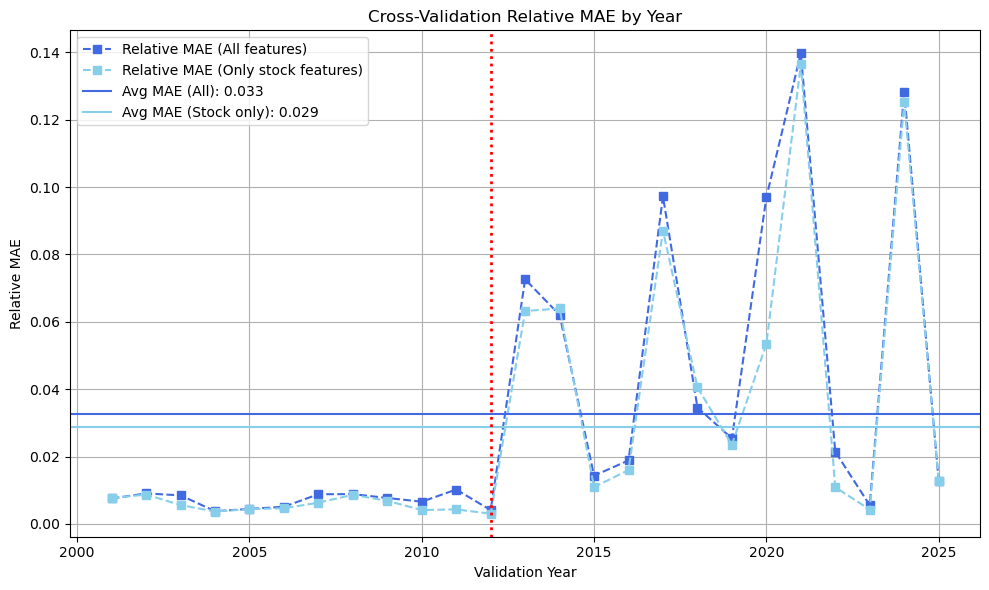

In [112]:
import matplotlib.pyplot as plt

# Sort results
cv_results_sorted = cv_results.sort_values(by='Validation Year')
cv_results_stock_sorted = cv_result_stock.sort_values(by='Validation Year')

# Calculate average MAE
avg_mae = cv_results_sorted['Relative MAE'].mean()
avg_mae_stock = cv_results_stock_sorted['Relative MAE'].mean()

# Plot
plt.figure(figsize=(10, 6))

# Line plots per year
plt.plot(cv_results_sorted['Validation Year'], cv_results_sorted['Relative MAE'], 
         marker='s', linestyle='--', color='royalblue', label='Relative MAE (All features)')
plt.plot(cv_results_stock_sorted['Validation Year'], cv_results_stock_sorted['Relative MAE'], 
         marker='s', linestyle='--', color='skyblue', label='Relative MAE (Only stock features)')

# Plot average MAE lines
plt.axhline(avg_mae, color='royalblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (All): {avg_mae:.3f}')
plt.axhline(avg_mae_stock, color='skyblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (Stock only): {avg_mae_stock:.3f}')

# Vertical line at 2012
plt.axvline(2012, color='red', linestyle=':', linewidth=2)

# Labels and legend
plt.xlabel('Validation Year')
plt.ylabel('Relative MAE')
plt.title('Cross-Validation Relative MAE by Year')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Random search

In [113]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# from sklearn.metrics import mean_absolute_error
# import random

# # --- Configuration ---
# target = 'Close'
# features = ['High', 'Low', 'Open', 'Volume']
# start_train_year = 2000
# end_val_year = 2024  # inclusive
# n_iterations = 30  # number of random parameter sets to try

# # Ensure data is sorted
# df = df.sort_values('Date').copy()
# df['year'] = df['Date'].dt.year

# import random

# # Continuous hyperparameter ranges
# param_grid = {
#     'max_depth': (3, 10),              # integer
#     'learning_rate': (0.01, 0.3),      # float
#     'subsample': (0.6, 1.0),           # float
#     'colsample_bytree': (0.6, 1.0)     # float
# }

# # Randomly sample from the continuous space
# def sample_params(grid):
#     return {
#         'max_depth': random.randint(*grid['max_depth']),
#         'learning_rate': round(random.uniform(*grid['learning_rate']), 4),
#         'subsample': round(random.uniform(*grid['subsample']), 4),
#         'colsample_bytree': round(random.uniform(*grid['colsample_bytree']), 4)
#     }

# # --- Optimization Loop ---
# best_score = float('inf')
# best_params = None
# all_results = []

# for i in range(n_iterations):
#     print(f"\n🔁 Trial {i + 1}/{n_iterations}")
#     params = sample_params(param_grid)
#     rel_maes = []

#     for val_year in range(start_train_year + 1, end_val_year + 1):
#         train_data = df[df['year'] < val_year]
#         val_data = df[df['year'] == val_year]

#         if val_data.empty:
#             continue

#         X_train = train_data[features]
#         y_train = train_data[target]
#         X_val = val_data[features]
#         y_val = val_data[target]

#         dtrain = xgb.DMatrix(X_train, label=y_train)
#         dvalid = xgb.DMatrix(X_val, label=y_val)

#         full_params = {
#             'booster': 'gbtree',
#             'objective': 'reg:squarederror',
#             'eval_metric': 'mae',
#             'verbosity': 0,
#             **params
#         }

#         model = xgb.train(
#             params=full_params,
#             dtrain=dtrain,
#             num_boost_round=1000,
#             evals=[(dtrain, 'train'), (dvalid, 'val')],
#             early_stopping_rounds=20,
#             verbose_eval=False
#         )

#         y_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
#         mae = mean_absolute_error(y_val, y_pred)
#         rel_mae = mae / abs(y_val.mean())
#         rel_maes.append(rel_mae)

#     avg_rel_mae = np.mean(rel_maes)
#     print(f"✅ Avg Relative MAE: {avg_rel_mae:.4f} with params: {params}")

#     all_results.append({
#         'params': params,
#         'avg_relative_mae': avg_rel_mae
#     })

#     if avg_rel_mae < best_score:
#         best_score = avg_rel_mae
#         best_params = params

# # --- Results ---
# print("\n🏆 Best Parameters Found:")
# print(best_params)
# print(f"With Avg Relative MAE: {best_score:.4f}")

# # Optional: Convert all results to a DataFrame
# results_df = pd.DataFrame([{
#     **r['params'],
#     'avg_relative_mae': r['avg_relative_mae']
# } for r in all_results])


In [114]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Configuration
target = 'Close'
features = ['High', 'Low', 'Open', 'Volume']
start_train_year = 2000
end_val_year = 2025  # inclusive

# Optimal parameters from your search
optimal_params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0,
    'max_depth': 5,
    'learning_rate': 0.1478,
    'subsample': 0.6858,
    'colsample_bytree': 0.8885
}

# Ensure data is sorted
df = df.sort_values('Date').copy()
df['year'] = df['Date'].dt.year

# Store results
results = []

for val_year in range(start_train_year + 1, end_val_year + 1):
    print(f"\n🔁 Training up to {val_year - 1}, validating on {val_year}")

    # Train: all years up to (not including) val_year
    train_data = df[df['year'] < val_year]
    val_data = df[df['year'] == val_year]

    # Drop if validation is empty
    if val_data.empty:
        print(f"⚠️ No validation data for {val_year}")
        continue

    # Define X/y
    X_train = train_data[features]
    y_train = train_data[target]
    X_val = val_data[features]
    y_val = val_data[target]

    # Train model
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    model = xgb.train(
        params=optimal_params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'val')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predict
    y_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))

    # Evaluate
    mae = mean_absolute_error(y_val, y_pred)
    rel_mae = mae / abs(y_val.mean())
    results.append({
        'Validation Year': val_year,
        'MAE': mae,
        'Relative MAE': rel_mae
    })
    print(f"✅ MAE: {mae:.4f}, Relative MAE: {rel_mae:.4f}")

# Convert to DataFrame
cv_result_optimal = pd.DataFrame(results)
print("\n📊 Cross-Validation Summary:")
print(cv_result_optimal)



🔁 Training up to 2000, validating on 2001


✅ MAE: 8.6519, Relative MAE: 0.0072

🔁 Training up to 2001, validating on 2002
✅ MAE: 8.0764, Relative MAE: 0.0081

🔁 Training up to 2002, validating on 2003
✅ MAE: 5.0260, Relative MAE: 0.0052

🔁 Training up to 2003, validating on 2004
✅ MAE: 3.8854, Relative MAE: 0.0034

🔁 Training up to 2004, validating on 2005
✅ MAE: 4.1435, Relative MAE: 0.0034

🔁 Training up to 2005, validating on 2006
✅ MAE: 4.6513, Relative MAE: 0.0035

🔁 Training up to 2006, validating on 2007
✅ MAE: 10.2947, Relative MAE: 0.0070

🔁 Training up to 2007, validating on 2008
✅ MAE: 10.2786, Relative MAE: 0.0084

🔁 Training up to 2008, validating on 2009
✅ MAE: 7.9936, Relative MAE: 0.0084

🔁 Training up to 2009, validating on 2010
✅ MAE: 4.8881, Relative MAE: 0.0043

🔁 Training up to 2010, validating on 2011
✅ MAE: 5.8286, Relative MAE: 0.0046

🔁 Training up to 2011, validating on 2012
✅ MAE: 4.1493, Relative MAE: 0.0030

🔁 Training up to 2012, validating on 2013
✅ MAE: 103.3087, Relative MAE: 0.0629

🔁 Training 

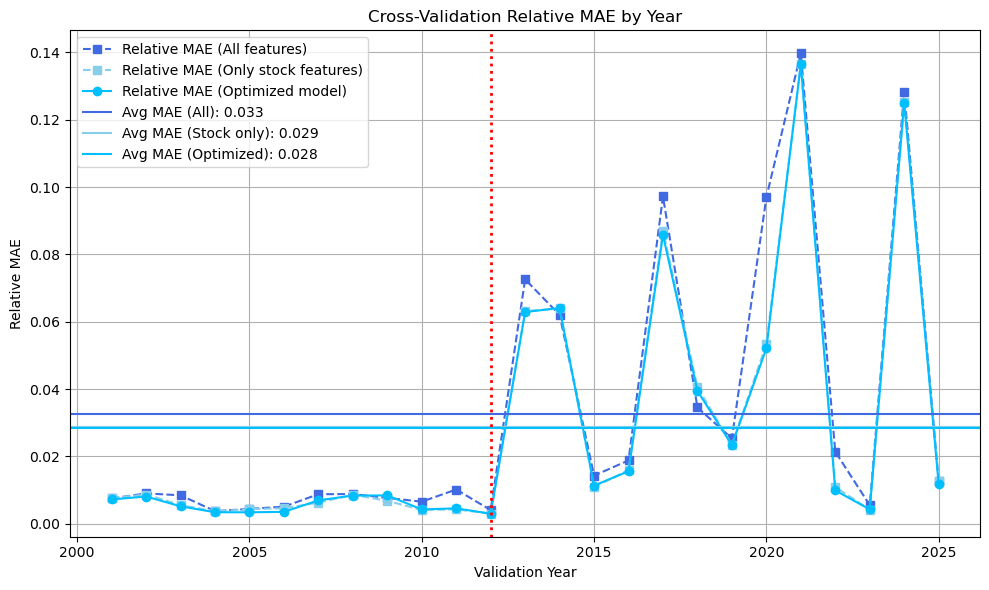

In [115]:
import matplotlib.pyplot as plt

# Sort results
cv_results_sorted = cv_results.sort_values(by='Validation Year')
cv_results_stock_sorted = cv_result_stock.sort_values(by='Validation Year')
cv_result_optimal_sorted = cv_result_optimal.sort_values(by='Validation Year')  # your new results

# Calculate average MAE
avg_mae = cv_results_sorted['Relative MAE'].mean()
avg_mae_stock = cv_results_stock_sorted['Relative MAE'].mean()
avg_mae_optimal = cv_result_optimal_sorted['Relative MAE'].mean()

# Plot
plt.figure(figsize=(10, 6))

# Line plots per year
plt.plot(cv_results_sorted['Validation Year'], cv_results_sorted['Relative MAE'], 
         marker='s', linestyle='--', color='royalblue', label='Relative MAE (All features)')
plt.plot(cv_results_stock_sorted['Validation Year'], cv_results_stock_sorted['Relative MAE'], 
         marker='s', linestyle='--', color='skyblue', label='Relative MAE (Only stock features)')
plt.plot(cv_result_optimal_sorted['Validation Year'], cv_result_optimal_sorted['Relative MAE'], 
         marker='o', linestyle='-', color='deepskyblue', label='Relative MAE (Optimized model)')

# Plot average MAE lines
plt.axhline(avg_mae, color='royalblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (All): {avg_mae:.3f}')
plt.axhline(avg_mae_stock, color='skyblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (Stock only): {avg_mae_stock:.3f}')
plt.axhline(avg_mae_optimal, color='deepskyblue', linestyle='-', linewidth=1.5, label=f'Avg MAE (Optimized): {avg_mae_optimal:.3f}')

# Vertical line at 2012
plt.axvline(2012, color='red', linestyle=':', linewidth=2)

# Labels and legend
plt.xlabel('Validation Year')
plt.ylabel('Relative MAE')
plt.title('Cross-Validation Relative MAE by Year')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Researching variance

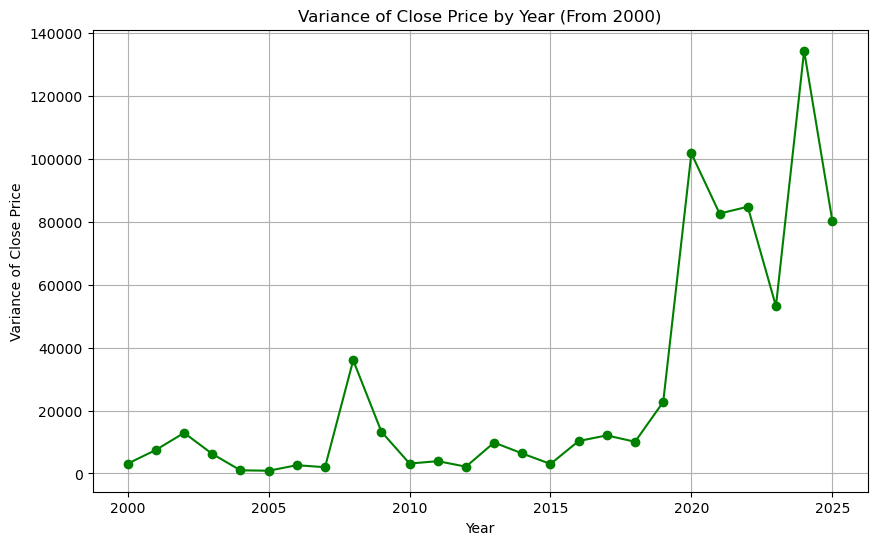

In [116]:
import matplotlib.pyplot as plt

# Calculate variance of Close price for each year
var_close = df.groupby('year')['Close'].var().reset_index()

# Filter to years >= 2000
var_close_filtered = var_close[var_close['year'] >= 2000]

# Plot variance over the years from 2000 onward
plt.figure(figsize=(10, 6))
plt.plot(var_close_filtered['year'], var_close_filtered['Close'], marker='o', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Variance of Close Price')
plt.title('Variance of Close Price by Year (From 2000)')
plt.grid(True)
plt.show()

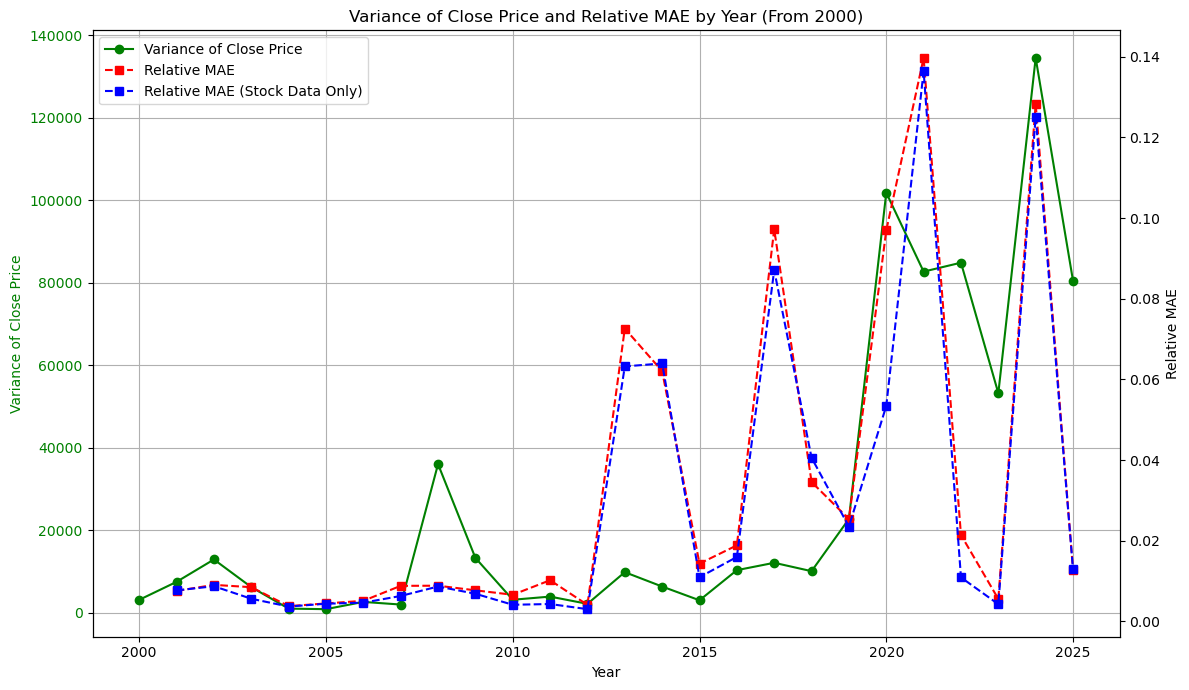

In [117]:
import matplotlib.pyplot as plt

# Filter data from year 2000 onwards
var_close_filtered = var_close[var_close['year'] >= 2000]
cv_results_sorted_filtered = cv_results[cv_results['Validation Year'] >= 2000].sort_values(by='Validation Year')
cv_results_stock_sorted_filtered = cv_result_stock[cv_result_stock['Validation Year'] >= 2000].sort_values(by='Validation Year')

fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot variance of Close price on primary y-axis
ax1.plot(var_close_filtered['year'], var_close_filtered['Close'], marker='o', color='green', label='Variance of Close Price')
ax1.set_xlabel('Year')
ax1.set_ylabel('Variance of Close Price', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True)

# Create secondary y-axis
ax2 = ax1.twinx()

# Plot Relative MAE on secondary y-axis
ax2.plot(cv_results_sorted_filtered['Validation Year'], cv_results_sorted_filtered['Relative MAE'], 
         marker='s', linestyle='--', color='red', label='Relative MAE')
ax2.plot(cv_results_stock_sorted_filtered['Validation Year'], cv_results_stock_sorted_filtered['Relative MAE'], 
         marker='s', linestyle='--', color='blue', label='Relative MAE (Stock Data Only)')
ax2.set_ylabel('Relative MAE', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Variance of Close Price and Relative MAE by Year (From 2000)')
plt.tight_layout()
plt.show()



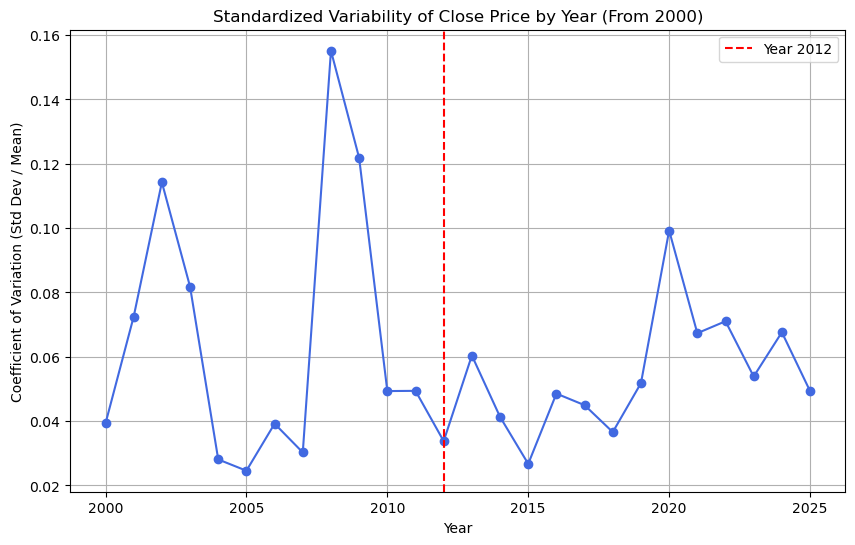

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate mean and variance of Close price for each year
stats = df.groupby('year')['Close'].agg(['mean', 'var']).reset_index()

# Filter to years >= 2000
stats_filtered = stats[stats['year'] >= 2000].copy()

# Calculate Coefficient of Variation = std dev / mean
stats_filtered['cv'] = np.sqrt(stats_filtered['var']) / stats_filtered['mean']

# Plot CV over the years from 2000 onward
plt.figure(figsize=(10, 6))
plt.plot(stats_filtered['year'], stats_filtered['cv'], marker='o', linestyle='-', color='royalblue')  # changed to blue
plt.axvline(x=2012, color='red', linestyle='--', label='Year 2012')  # added vertical line
plt.xlabel('Year')
plt.ylabel('Coefficient of Variation (Std Dev / Mean)')
plt.title('Standardized Variability of Close Price by Year (From 2000)')
plt.grid(True)
plt.legend()
plt.show()


In [119]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Configuration
target = 'Close'
start_train_year = 2000
end_val_year = 2024  # inclusive

# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').copy()
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['dayofweek'] = df['Date'].dt.dayofweek

# Add lag features
lags = [1, 2, 3, 5, 10]
for lag in lags:
    df[f'lag_{lag}'] = df[target].shift(lag)

# Drop rows with NaN values from lagging
df = df.dropna().reset_index(drop=True)

# Store results
results = []

for val_year in range(start_train_year + 1, end_val_year + 1):  # train on ALL years before val_year
    print(f"\n🔁 Training on all years before {val_year}, validating on {val_year}")

    # Filter data
    train_data = df[df['year'] < val_year]
    val_data = df[df['year'] == val_year]

    # Skip if no validation data
    if val_data.empty or train_data.empty:
        print(f"⚠️ Skipping {val_year} (no data)")
        continue

    # Define features
    features = [col for col in df.columns if col not in [target, 'Date', 'year']]

    # Define X/y
    X_train = train_data[features]
    y_train = train_data[target]
    X_val = val_data[features]
    y_val = val_data[target]

    # Convert to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_val, label=y_val)

    # Model params
    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'verbosity': 0
    }

    # Train model
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dvalid, 'val')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predict and evaluate
    y_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    mae = mean_absolute_error(y_val, y_pred)
    rel_mae = mae / abs(y_val.mean())

    results.append({
        'Validation Year': val_year,
        'MAE': mae,
        'Relative MAE': rel_mae
    })
    print(f"✅ MAE: {mae:.4f}, Relative MAE: {rel_mae:.4f}")

# Final results
cv_results = pd.DataFrame(results)
print("\n📊 Cross-Validation Summary:")
print(cv_results)



🔁 Training on all years before 2001, validating on 2001
✅ MAE: 9.4792, Relative MAE: 0.0079

🔁 Training on all years before 2002, validating on 2002
✅ MAE: 9.7911, Relative MAE: 0.0098

🔁 Training on all years before 2003, validating on 2003
✅ MAE: 9.8581, Relative MAE: 0.0102

🔁 Training on all years before 2004, validating on 2004
✅ MAE: 4.7075, Relative MAE: 0.0042

🔁 Training on all years before 2005, validating on 2005
✅ MAE: 5.2184, Relative MAE: 0.0043

🔁 Training on all years before 2006, validating on 2006
✅ MAE: 11.8605, Relative MAE: 0.0091

🔁 Training on all years before 2007, validating on 2007
✅ MAE: 17.9037, Relative MAE: 0.0121

🔁 Training on all years before 2008, validating on 2008
✅ MAE: 10.8877, Relative MAE: 0.0089

🔁 Training on all years before 2009, validating on 2009
✅ MAE: 8.4242, Relative MAE: 0.0089

🔁 Training on all years before 2010, validating on 2010
✅ MAE: 6.9060, Relative MAE: 0.0061

🔁 Training on all years before 2011, validating on 2011
✅ MAE: 9.4

In [120]:
# Print as a nice table
print("\n📊 Cross-Validation Summary (sorted by year):")
print(cv_results.to_string(index=False))



📊 Cross-Validation Summary (sorted by year):
 Validation Year        MAE  Relative MAE
            2001   9.479206      0.007932
            2002   9.791053      0.009840
            2003   9.858124      0.010220
            2004   4.707476      0.004164
            2005   5.218421      0.004323
            2006  11.860483      0.009052
            2007  17.903746      0.012121
            2008  10.887715      0.008899
            2009   8.424210      0.008896
            2010   6.906002      0.006060
            2011   9.467186      0.007467
            2012   4.856292      0.003521
            2013 113.265212      0.068937
            2014 116.658124      0.060408
            2015  26.954993      0.013077
            2016  35.755773      0.017075
            2017 222.490990      0.090829
            2018  93.368091      0.034005
            2019  84.801255      0.029117
            2020 328.232741      0.102088
            2021 601.193481      0.140744
            2022  77.504904   

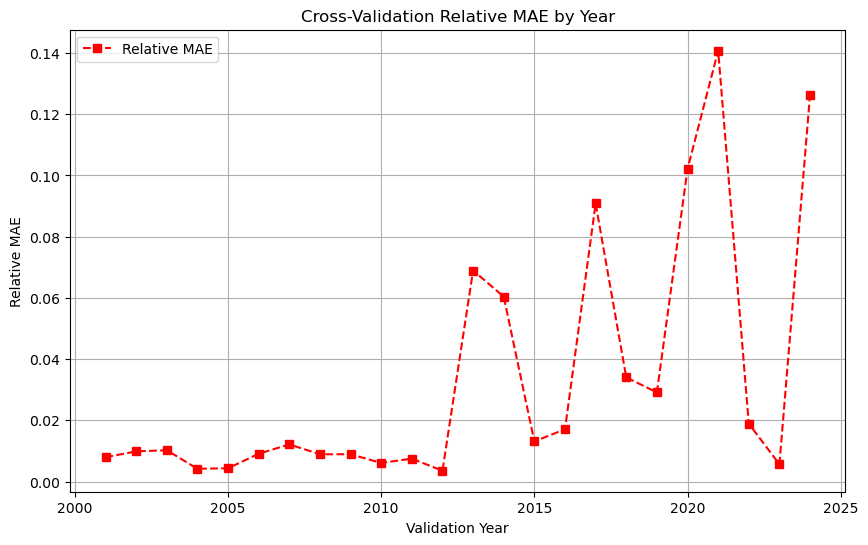

In [121]:
import matplotlib.pyplot as plt

cv_results_sorted = cv_results.sort_values(by='Validation Year')

# Plot only Relative MAE
plt.figure(figsize=(10, 6))
plt.plot(cv_results_sorted['Validation Year'], cv_results_sorted['Relative MAE'], 
         marker='s', linestyle='--', color='red', label='Relative MAE')

plt.xlabel('Validation Year')
plt.ylabel('Relative MAE')
plt.title('Cross-Validation Relative MAE by Year')
plt.grid(True)
plt.legend()
plt.show()




## Making a XGboost models - Test set (2025)

### Predicting with XGboost with time series

#### Baseline model

In [170]:
# Example: use data before a date for training, after that date for testing

split_date = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [171]:
def create_lags(df, target_col, lags=[1,2,3]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

train_data = create_lags(train_data, target)
test_data = create_lags(test_data, target)

# Drop NA rows caused by shifting lags
train_data = train_data.dropna()
test_data = test_data.dropna()

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]
X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [172]:
def add_date_features(df):
    df = df.copy()
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['weekday'] = df['Date'].dt.weekday
    df['dayofyear'] = df['Date'].dt.dayofyear
    return df

train_data = add_date_features(train_data)
test_data = add_date_features(test_data)

X_train = train_data.drop(columns=[target, 'Date'])
X_test = test_data.drop(columns=[target, 'Date'])


In [173]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred)

mean_abs_actual = abs(Y_test).mean()
relative_mae = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 98.5173
Relative MAE: 0.0172
Time used by XGBoost: 151.3 ms


#### Feature importance

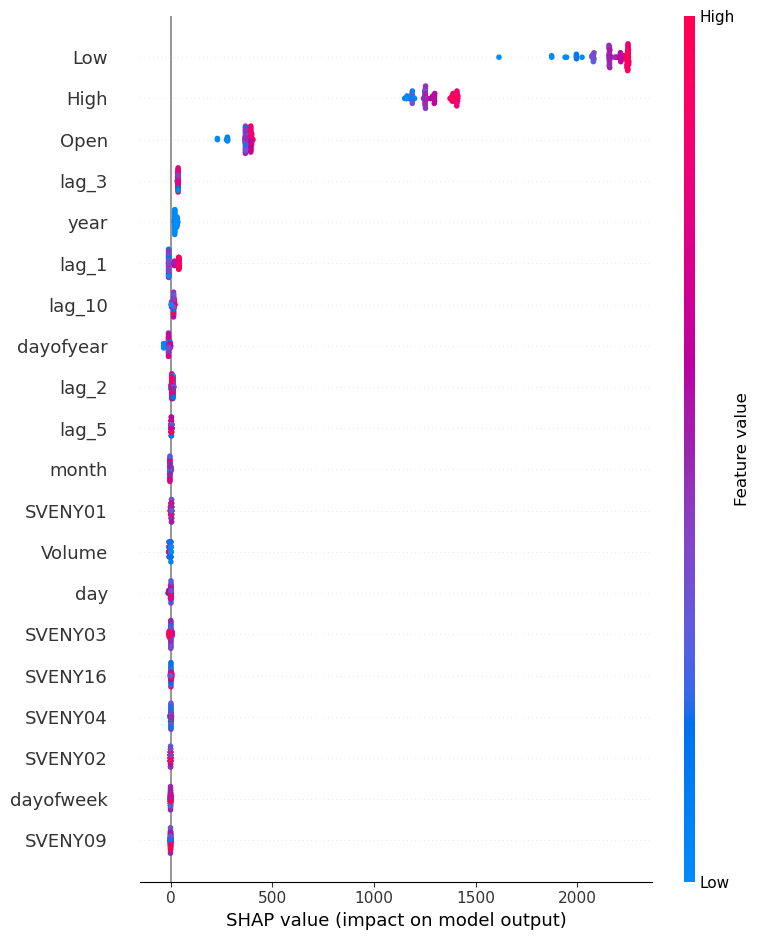

In [174]:
import shap

# Create a SHAP explainer for your XGBoost model
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for your test set
shap_values = explainer(X_test)

# Summary plot (shows feature importance and effect)
shap.summary_plot(shap_values, X_test)


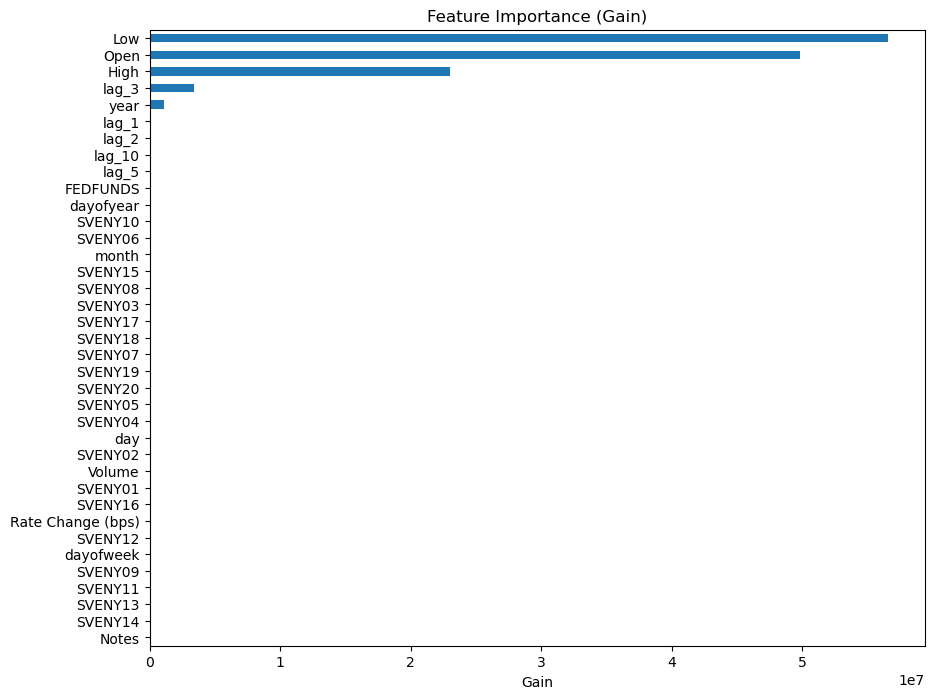

In [175]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance scores by 'gain'
importance = xgb_model.get_score(importance_type='gain')

# Convert to pandas Series for easier plotting and sorting
import pandas as pd
importance_series = pd.Series(importance).sort_values(ascending=True)

# Plot
plt.figure(figsize=(10, 8))
importance_series.plot(kind='barh')
plt.xlabel('Gain')
plt.title('Feature Importance (Gain)')
plt.show()


#### Only predicting on ZCB data but with lags

In [176]:
data_ZCB = df.drop(columns=['Open', 'High', 'Low', 'Volume'])

In [177]:
# Example: use data before a date for training, after that date for testing

split_date = pd.Timestamp('2025-01-01')

train_data = data_ZCB[data_ZCB['Date'] < split_date]
test_data = data_ZCB[data_ZCB['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [178]:
def create_lags(df, target_col, lags=[1,2,3]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

train_data = create_lags(train_data, target)
test_data = create_lags(test_data, target)

# Drop NA rows caused by shifting lags
train_data = train_data.dropna()
test_data = test_data.dropna()

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]
X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

In [179]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_ZCB)

mean_abs_actual = abs(Y_test).mean()
relative_mae_wo_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 94.3035
Relative MAE: 0.0172
Time used by XGBoost: 138.3 ms


#### Only predicting on stock data but with lags

In [180]:
data_stock = df[['Date', 'Close', 'High', 'Low', 'Volume', 'Open']]

In [181]:
# Example: use data before a date for training, after that date for testing

split_date = pd.Timestamp('2025-01-01')

train_data = data_stock[data_stock['Date'] < split_date]
test_data = data_stock[data_stock['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]


In [182]:
def create_lags(df, target_col, lags=[1,2,3]):
    df = df.copy()
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    return df

train_data = create_lags(train_data, target)
test_data = create_lags(test_data, target)

# Drop NA rows caused by shifting lags
train_data = train_data.dropna()
test_data = test_data.dropna()

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]
X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

In [183]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time

start = time.time()

dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_stock)

mean_abs_actual = abs(Y_test).mean()
relative_mae_stock = mae / mean_abs_actual

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")


Mean Absolute Error: 72.6679
Relative MAE: 0.0172
Time used by XGBoost: 66.2 ms


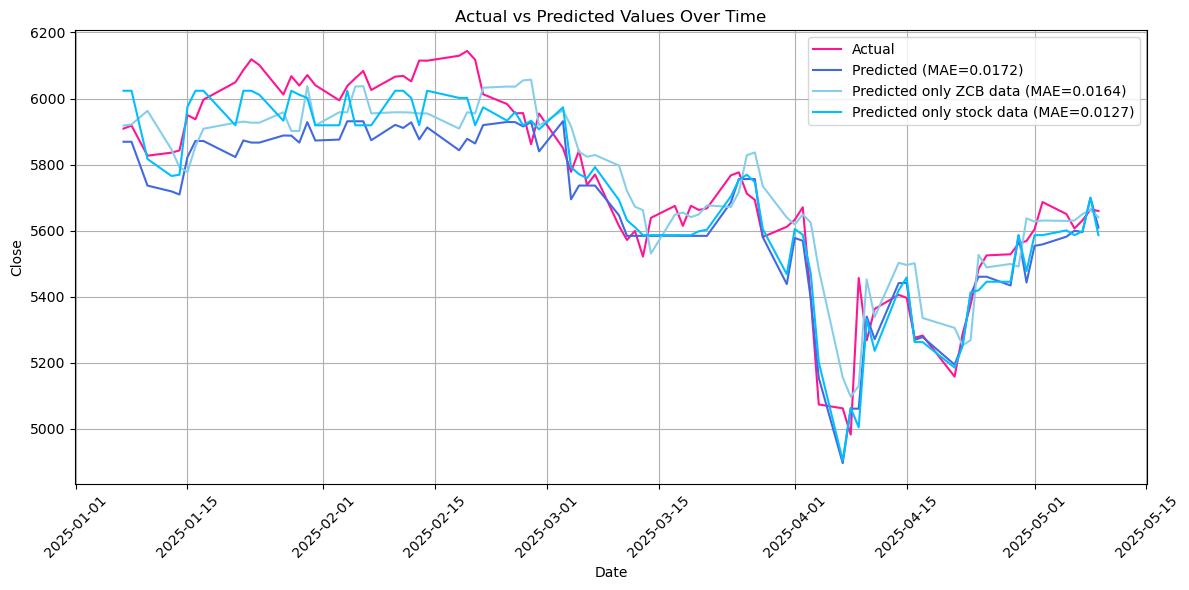

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], Y_test, label='Actual', color='deeppink')
plt.plot(test_data['Date'], y_pred, 
         label=f'Predicted (MAE={relative_mae:.4f})', 
         color='royalblue')
plt.plot(test_data['Date'], y_pred_ZCB, 
         label=f'Predicted only ZCB data (MAE={relative_mae_wo_stock:.4f})', 
         color='skyblue')
plt.plot(test_data['Date'], y_pred_stock, 
         label=f'Predicted only stock data (MAE={relative_mae_stock:.4f})', 
         color='deepskyblue')

plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close')  # or your target variable name
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # rotate date labels for readability
plt.tight_layout()       # adjust layout to prevent cutoff
plt.show()



### Predicting with XGboost

#### Predicting with stock data

In [160]:
# Example: use data before a date for training, after that date for testing

split_date = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

target = 'Close'

X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

In [161]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

# Assume data_w_SP is your full DataFrame with 'Date' as datetime

# Define split date for time split
split_date = pd.Timestamp('2025-01-01')

# Split data by date (time split)
train_data = data_w_SP[data_w_SP['Date'] < split_date]
test_data = data_w_SP[data_w_SP['Date'] >= split_date]

target = 'Close'

# Prepare features and target - no lag features, no date column
X_train = train_data.drop(columns=[target, 'Date'])
Y_train = train_data[target]

X_test = test_data.drop(columns=[target, 'Date'])
Y_test = test_data[target]

# Start timer
start = time.time()

# Drop rows with any missing values from train and test
train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

# Prepare features and target again after dropping NA rows
X_train = train_data_clean.drop(columns=[target, 'Date'])
Y_train = train_data_clean[target]

X_test = test_data_clean.drop(columns=[target, 'Date'])
Y_test = test_data_clean[target]

# Now create DMatrices for XGBoost
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)


# XGBoost parameters
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

# Train model with early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

# Predict and evaluate
y_pred = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred)
relative_mae = mae / abs(Y_test).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")



Mean Absolute Error: 73.5767
Relative MAE: 0.0128
Time used by XGBoost: 147.0 ms


#### Predicting without stock data

In [162]:
split_date = pd.Timestamp('2025-01-01')

train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

target = 'Close'

In [163]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

# Drop rows with any missing values from train and test first
train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

# Define columns to drop including target, date, and Open/High/Low
cols_to_drop = [target, 'Date', 'Open', 'High', 'Low', 'Volume']

# Prepare features and target after dropping NA rows
X_train = train_data_clean.drop(columns=cols_to_drop)
Y_train = train_data_clean[target]

X_test = test_data_clean.drop(columns=cols_to_drop)
Y_test = test_data_clean[target]

# Start timer
start = time.time()

# Create DMatrices for XGBoost
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

# XGBoost parameters
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

# Train model with early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

# Predict and evaluate
y_pred_ZCB = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_ZCB)
relative_mae_wo_stock = mae / abs(Y_test).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae_wo_stock:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")




Mean Absolute Error: 103.2689
Relative MAE: 0.0180
Time used by XGBoost: 177.2 ms


#### Predicting only stock data

In [165]:
split_date = pd.Timestamp('2025-01-01')

train_data = data_w_SP[data_w_SP['Date'] < split_date]
test_data = data_w_SP[data_w_SP['Date'] >= split_date]

target = 'Close'

In [166]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import time
import pandas as pd

# Drop rows with any missing values from train and test first
train_data_clean = train_data.dropna()
test_data_clean = test_data.dropna()

# Select only Open, High, Low as features
feature_cols = ['Open', 'High', 'Low', 'Volume']

# Prepare features and target after drop,ping NA rows
X_train = train_data_clean[feature_cols]
Y_train = train_data_clean[target]

X_test = test_data_clean[feature_cols]
Y_test = test_data_clean[target]

# Start timer
start = time.time()

# Create DMatrices for XGBoost
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)

# XGBoost parameters
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'verbosity': 0
}

evals = [(dtrain, 'train'), (dvalid, 'eval')]

# Train model with early stopping
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

# Predict and evaluate
y_pred_stock = xgb_model.predict(dvalid, iteration_range=(0, xgb_model.best_iteration + 1))
mae = mean_absolute_error(Y_test, y_pred_stock)
relative_mae_stock = mae / abs(Y_test).mean()

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Relative MAE: {relative_mae_stock:.4f}")
print(f"Time used by XGBoost: {(time.time() - start) * 1000:.1f} ms")




Mean Absolute Error: 72.7207
Relative MAE: 0.0126
Time used by XGBoost: 224.9 ms


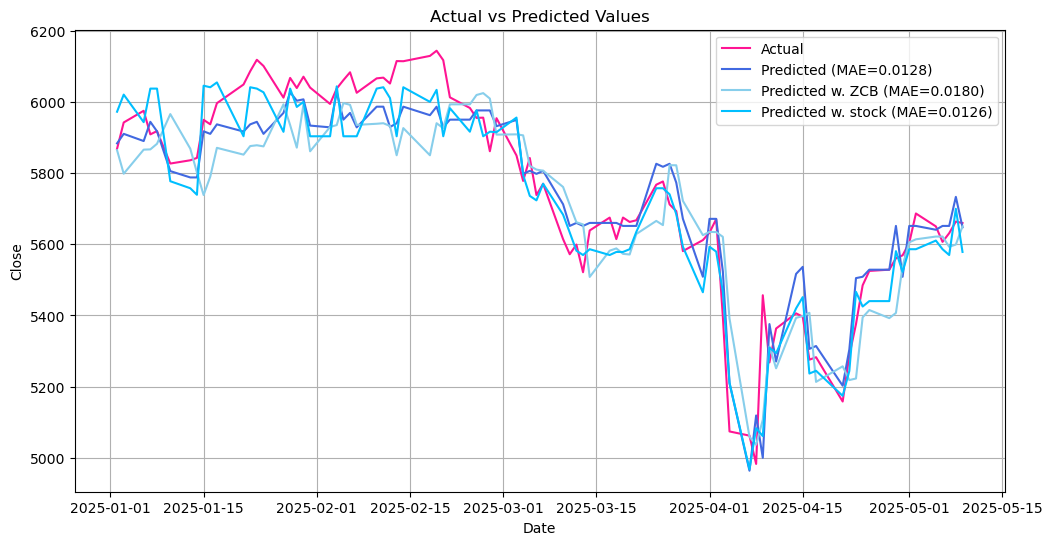

In [169]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data_clean['Date'], Y_test, label='Actual', color='deeppink')
plt.plot(test_data_clean['Date'], y_pred, label=f'Predicted (MAE={relative_mae:.4f})', color='royalblue')
plt.plot(test_data_clean['Date'], y_pred_ZCB, label=f'Predicted w. ZCB (MAE={relative_mae_wo_stock:.4f})', color='skyblue')
plt.plot(test_data_clean['Date'], y_pred_stock, label=f'Predicted w. stock (MAE={relative_mae_stock:.4f})', color='deepskyblue')

plt.xlabel('Date')
plt.ylabel(target)
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
